In [ ]:
import sys, platform

base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'

if platform.system() is 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [17]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.impute import KNNImputer
import src.filler as fl
from src.filler import RandomForestFillerWithOneModel, LstmFillerModel, HodmdFiller, Debbuger
from src.dataframe import read_data_from_csv, show_error_metrics, split_data, windowing_nparray

In [ ]:
filename = f'{base_path}/data/daily_vicosa.csv'

In [ ]:
df = read_data_from_csv(filename)

df = df.RADIATION

In [ ]:
data = fl.FillerHelper.get_largest_complete_interval(df)
data_with_gaps = fl.FillerHelper.introduce_gaps(data.copy(), 
                                                missing_percentage=0.02, 
                                                min_gap_size=1, 
                                                max_gap_size=20)

3839
713
Percentual de dados faltantes: 0.18572544933576451


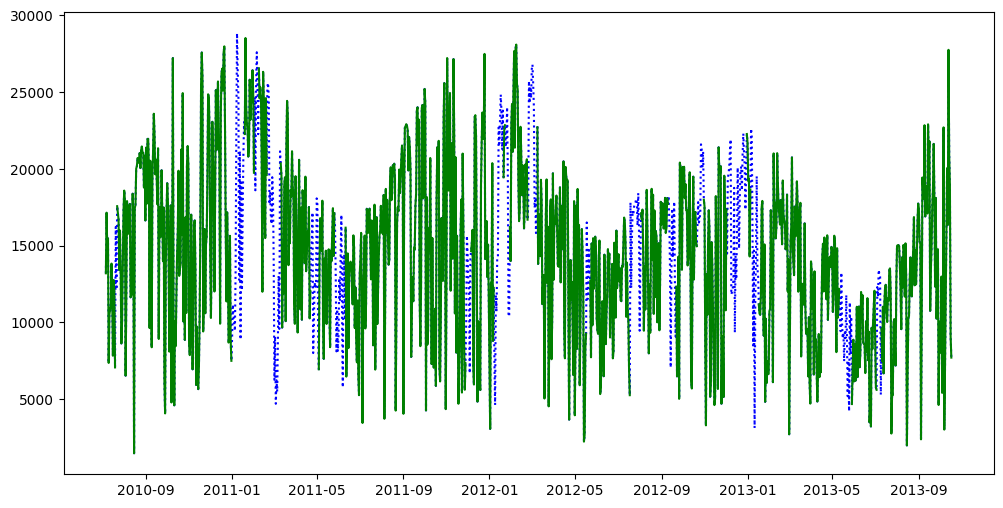

In [31]:
maxrange = 1200

print(len(data))
print(data_with_gaps.isna().sum())
print('Percentual de dados faltantes:', (data_with_gaps.isna().sum()/len(data)))

pyplot.figure(figsize=(12, 6))
pyplot.plot(data[0:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_with_gaps[0:maxrange], color='green', label='missing_data')
pyplot.show()

DMD

In [ ]:
def objective(trial):
    dmd_data = data_with_gaps.copy()
    filler = fl.HodmdFiller(d_factor=trial.suggest_float("d_fator", 0.5, 0.99, log=True))
    data_filled = filler.dmd_filler(dmd_data)
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    return mae


study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'hodmd',
    load_if_exists=True
)

n_trials = 8
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Interpolation Seasonal

In [ ]:
def objective(trial):
    data_filled = fl.seasonal_filler(data_with_gaps.copy(), 
                                     period=trial.suggest_int("period", 24, 365, log=True), 
                                     factor=trial.suggest_int("factor", 1, 6, log=True))
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    print('Faltantes SCORE:', data_filled.isna().sum())
    return mae



study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'interpolation_seasonal_new',
    load_if_exists=True
)

n_trials = 100
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Random forest

In [ ]:
def objective(trial):
    rf_data = data_with_gaps.copy()
    filler_model = RandomForestFillerWithOneModel(
        n_estimators=trial.suggest_int("estimators", 100, 5000, log=True), 
        n_in=trial.suggest_int("n_in", 1, 15, log=True), 
        n_out=1)
    data_filled = filler_model.filler(rf_data)
    mae = mean_absolute_error(data, data_filled)
    print('MAE SCORE:', mae)
    print('Faltantes SCORE:', data_filled.isna().sum())
    return mae



study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///filler_method.db',
    study_name=f'random_forest',
    load_if_exists=True
)

n_trials = 40
if len(study.trials) < n_trials:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=600, 
        gc_after_trial=True,
        n_jobs=4
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def windowing_nparray(values, step_back, step_front) -> (np.array, np.array):
    x, y = [], []
    for i in range(len(values) - step_back - step_front):
        j = (i + step_back)
        x.append(values[i:j])
        y.append(values[j:(j+step_front), 0])

    return np.array(x), np.array(y)

def knn_filler(data, k):
    imputer = KNNImputer(n_neighbors=k)
    filled_data_knn = imputer.fit_transform(data.values.reshape(-1,1))
    return pd.Series(filled_data_knn.ravel(), name=data.name, index=data.index.values)

def train_model(train_x, train_y, is_debug):
    model = Sequential([
        InputLayer(input_shape=(train_x.shape[1], train_x.shape[2])),
        LSTM(units=350),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())

    Debbuger.log(is_debug, 'Model Summary', model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

    history = model.fit(train_x,
                        train_y,
                        epochs=5000,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=0,
                        callbacks=[es],
                        workers=4,
                        use_multiprocessing=True)

    # plot history
    if is_debug:
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

    return model

In [ ]:
step_back = 10
ratio = 0.9

scaler = MinMaxScaler(feature_range=(0,1))

data_scaled = scaler.fit_transform(data.values.reshape(-1,1))

X, Y = windowing_nparray(data_scaled, step_back=step_back, step_front=1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(data_scaled), ratio=ratio)

real_test_y = scaler.inverse_transform(test_y.reshape(-1,1))

In [ ]:
# Completa
dmd_data = data_with_gaps.copy()
filler = fl.HodmdFiller(d_factor=0.99)
data_filled = filler.dmd_filler(dmd_data)

# Métricas
print('Input metrics')
show_error_metrics(data, data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
dmd_data_scaled = scaler.transform(data_filled.values.reshape(-1,1))
dmd_X, dmd_Y = windowing_nparray(dmd_data_scaled, step_back=step_back, step_front=1)
dmd_train_x, dmd_train_y, dmd_test_x, dmd_test_y = split_data(X, Y, length=len(dmd_data_scaled), ratio=ratio)

#Treinando model
model = train_model(dmd_train_x, dmd_train_y, True)
predict = model.predict(test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1,1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y.reshape(-1,1)[:range_plot], color='blue', label='Real')
pyplot.plot(predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
pyplot.show()

In [ ]:
# Completa
seasonal_data = data_with_gaps.copy()
seasonal_data_filled = fl.seasonal_filler(seasonal_data, 
                                            period=347, 
                                            factor=6)

# Métricas
print('Input metrics')
show_error_metrics(data, seasonal_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(seasonal_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
seasonal_data_scaled = scaler.transform(seasonal_data_filled.values.reshape(-1,1))
seasonal_X, seasonal_Y = windowing_nparray(seasonal_data_scaled, step_back=step_back, step_front=1)
seasonal_train_x, seasonal_train_y, seasonal_test_x, seasonal_test_y = split_data(X, Y, length=len(seasonal_data_scaled), ratio=ratio)

#Treinando model
model = train_model(seasonal_train_x, seasonal_train_y, True)
predict = model.predict(test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

In [ ]:
# Completa
rf_data = data_with_gaps.copy()
filler_model = RandomForestFillerWithOneModel(
    n_estimators=1500, 
    n_in=3, 
    n_out=1)
rf_data_filled = filler_model.filler(rf_data)

# Métricas
print('Input metrics')
show_error_metrics(data, rf_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(rf_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
rf_data_scaled = scaler.transform(rf_data_filled.values.reshape(-1,1))
rf_X, rf_Y = windowing_nparray(rf_data_scaled, step_back=step_back, step_front=1)
rf_train_x, rf_train_y, rf_test_x, rf_test_y = split_data(X, Y, length=len(rf_data_scaled), ratio=ratio)

#Treinando model
model = train_model(rf_train_x, rf_train_y, True)
predict = model.predict(test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

In [ ]:
# Completa
interpolate_data = data_with_gaps.copy()
interpolate_data_filled = interpolate_data.interpolate(method='linear')

# Métricas
print('Input metrics')
show_error_metrics(data, interpolate_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(interpolate_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
interpolate_data_scaled = scaler.transform(interpolate_data_filled.values.reshape(-1,1))
interpolate_X, interpolate_Y = windowing_nparray(interpolate_data_scaled, step_back=step_back, step_front=1)
interpolate_train_x, interpolate_train_y, interpolate_test_x, interpolate_test_y = split_data(X, Y, length=len(interpolate_data_scaled), ratio=ratio)

#Treinando model
model = train_model(interpolate_train_x, interpolate_train_y, True)
predict = model.predict(test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()

Input metrics
Test R2: 0.811
Test MSE: 6493640.158
Test RMSE: 2548.262
Test MAE: 911.120
Test MAPE: 0.073


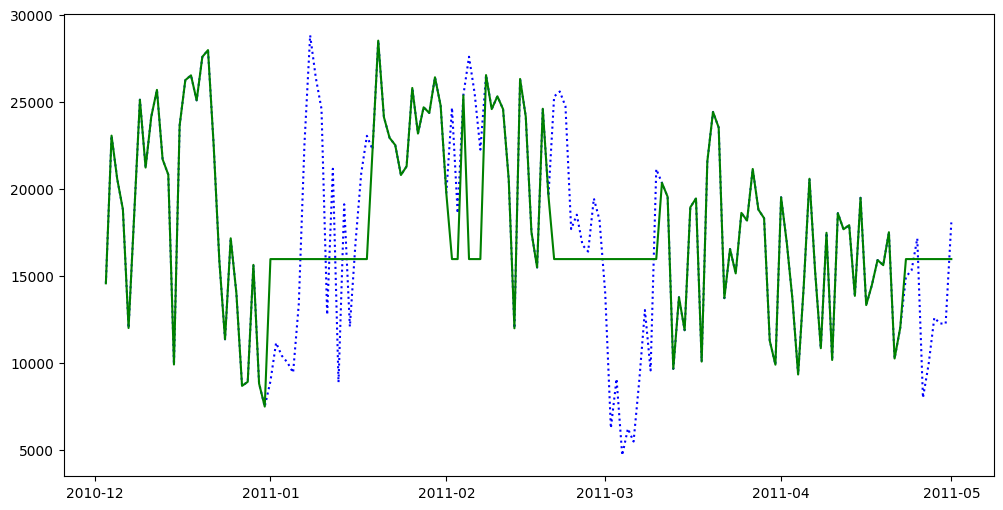

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 350)               492800    
                                                                 
 dense_1 (Dense)             (None, 1)                 351       
                                                                 
Total params: 493151 (1.88 MB)
Trainable params: 493151 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
('Model Summary', None)
Restoring model weights from the end of the best epoch: 22.
Epoch 42: early stopping


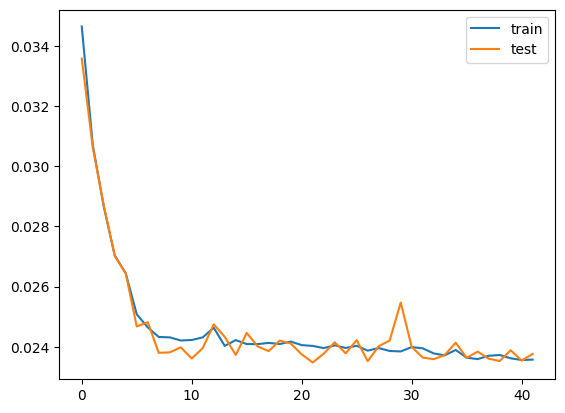

12/12 [==============================] - 0s 6ms/step
Forecasting
Test R2: 0.324
Test MSE: 21718741.014
Test RMSE: 4660.337
Test MAE: 3629.756
Test MAPE: 0.345


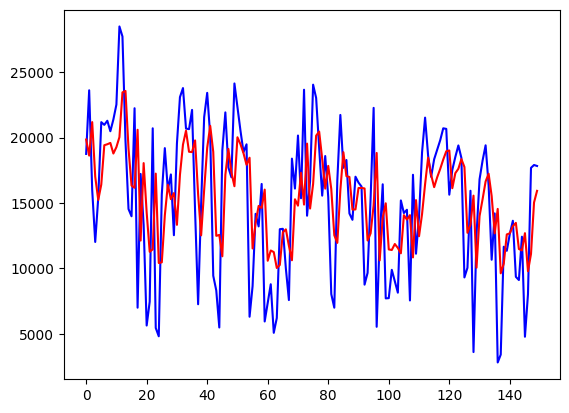

In [30]:
# Completa
knn_data = data_with_gaps.copy()
knn_data_filled = knn_filler(knn_data, k=5)

# Métricas
print('Input metrics')
show_error_metrics(data, knn_data_filled)
maxrange = 300
pyplot.figure(figsize=(12, 6))
pyplot.plot(data[150:maxrange], color = 'b', linestyle = ':')
pyplot.plot(knn_data_filled[150:maxrange], color='green', label='missing_data')
pyplot.show()

# Preparando os dados
knn_data_scaled = scaler.transform(knn_data_filled.values.reshape(-1,1))
knn_X, knn_Y = windowing_nparray(knn_data_scaled, step_back=step_back, step_front=1)
knn_train_x, knn_train_y, knn_test_x, knn_test_y = split_data(X, Y, length=len(knn_data_scaled), ratio=ratio)

#Treinando model
model = train_model(knn_train_x, knn_train_y, True)
predict = model.predict(test_x, batch_size=32)
predict = scaler.inverse_transform(predict.reshape(-1, 1))

# Avaliando previsão
range_plot = 150
print('Forecasting')
show_error_metrics(real_test_y, predict)
pyplot.plot(real_test_y[:range_plot], color='blue', label='Real')
pyplot.plot(predict[:range_plot], color='red', label='Previsão')
pyplot.show()